Training agents across mazes...ERROR! Session/line number was not unique in database. History logging moved to new session 102


Training agents on maze 1...
Agent 1 completed training on maze with total reward: 50895.0
Agent 2 completed training on maze with total reward: 47885.0
Best agent selected with reward: 50895.0

Training agents on maze 2...
Agent 1 completed training on maze with total reward: 43215.0
Agent 2 completed training on maze with total reward: 38510.0
Best agent selected with reward: 43215.0

Training agents on maze 3...
Agent 1 completed training on maze with total reward: 39025.0
Agent 2 completed training on maze with total reward: 33805.0
Best agent selected with reward: 39025.0

Training agents on maze 4...
Agent 1 completed training on maze with total reward: 24945.0
Agent 2 completed training on maze with total reward: 26445.0
Best agent selected with reward: 26445.0

Training agents on maze 5...
Agent 1 completed training on maze with total reward: 30865.0


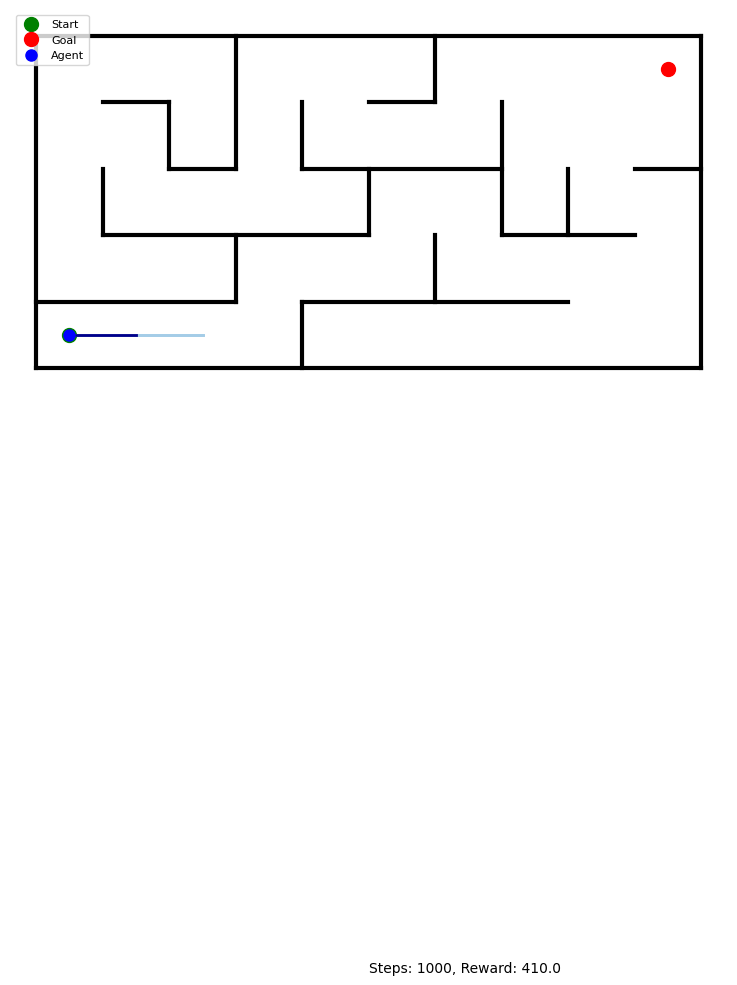

In [6]:
import json
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import animation
from collections import deque, defaultdict, Counter
import torch
import torch.nn as nn
import torch.optim as optim
import math

# ============ PARAMETER ============ #
MAZE_FILE_PATH = "./test_data/test2_15.json"
MAZE_SIZE = (10, 5)
NUM_AGENTS = 2
STARTING_POSITION = (0.5, 0.5)
GOAL_POSITION = (9.5, 4.5)

BATCH_SIZE = 32
HIDDEN_SIZE = 24

TRAINING_EPISODES = 20
LEARNING_RATE = 0.05
GAMMA = 0.995
EPSILON_DECAY = 0.85
MIN_EPSILON = 0.05
SEQUENCE_LENGTH = 4
MAX_STEPS_PER_EPISODE = 1000

REWARD_GOAL = 100000             
REWARD_NEW_POSITION = 100

PENALTY_REVISIT = -5
PENALTY_WALL_COLLISION = -100
PENALTY_REPETITIVE_ACTION = -100
PENALTY_FAILED_ACTION = -100

MAX_REPETITIVE_ACTIONS = 2  
DECAYING_REVISIT_FACTOR = 3 
BACKTRACK_HISTORY_LENGTH = 2 
PROXIMITY_REWARD_FACTOR = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============ ENVIRONMENT LOADING ============ #
def load_mazes_from_json(filepath):
    """Load maze data from a JSON file."""
    with open(filepath, "r") as file:
        mazes = json.load(file)
    return mazes

# ============ ENVIRONMENT CLASS ============ #
class MazeEnv:
    def __init__(self, maze_data, starting_position=STARTING_POSITION, goal_position=GOAL_POSITION):
        self.width = maze_data.get("width", MAZE_SIZE[0])
        self.height = maze_data.get("height", MAZE_SIZE[1])
        self.start_position = starting_position
        self.goal_position = goal_position
        self.walls = [frozenset({tuple(wall["start_position"]), tuple(wall["end_position"])}) for wall in maze_data["walls"]]
        self.walls_sorted_by_x, self.walls_sorted_by_y = self.preprocess_walls(self.walls)
        self.failed_actions = defaultdict(set)  # Track failed actions at each cell
        self.reset()

    def preprocess_walls(self, walls):
        """Sort walls by coordinates for optimized wall detection."""
        walls_as_tuples = [tuple(sorted(wall)) for wall in walls]
        walls_sorted_by_x = sorted(walls_as_tuples, key=lambda wall: (min(wall[0][0], wall[1][0]), min(wall[0][1], wall[1][1])))
        walls_sorted_by_y = sorted(walls_as_tuples, key=lambda wall: (min(wall[0][1], wall[1][1]), min(wall[0][0], wall[1][0])))
        return walls_sorted_by_x, walls_sorted_by_y

    def reset(self):
        """Reset environment to the starting position and initialize visited positions and recent history."""
        self.position = self.start_position
        self.done = False
        self.visited_positions = {self.position}  # Track visited positions
        self.recent_positions = deque(maxlen=BACKTRACK_HISTORY_LENGTH)  # Track recent positions
        self.failed_actions.clear()  # Clear failed actions tracking
        self.recent_positions.append(self.position)
        return self.position
    
    def hits_wall(self, position, new_position):
        """Check if a movement would hit a wall, using sorted lists of walls for faster searching."""
        x, y = position
        nx, ny = new_position
        curr_x, curr_y = int(x), int(y)
        next_x, next_y = int(nx), int(ny)

        movement_direction = (
            "north" if ny > y else "south" if ny < y else "east" if nx > x else "west"
        ) if nx != x or ny != y else None

        if not movement_direction:
            return False  # No movement

        relevant_walls = self.walls_sorted_by_y if movement_direction in ["north", "south"] else self.walls_sorted_by_x
        for wall in relevant_walls:
            (wx1, wy1), (wx2, wy2) = sorted(wall)
            if movement_direction == "north" and wy1 == curr_y + 1 and wx1 <= curr_x < wx2:
                return True
            elif movement_direction == "south" and wy1 == curr_y and wx1 <= curr_x < wx2:
                return True
            elif movement_direction == "east" and wx1 == curr_x + 1 and wy1 <= curr_y < wy2:
                return True
            elif movement_direction == "west" and wx1 == curr_x and wy1 <= curr_y < wy2:
                return True
        return False

    def proximity_reward(self, position):
        """Calculate proximity reward based on distance to the goal."""
        distance = math.sqrt((position[0] - self.goal_position[0]) ** 2 + (position[1] - self.goal_position[1]) ** 2)
        return PROXIMITY_REWARD_FACTOR * (1 / (1 + distance))

    def is_valid_position(self, position):
        """Ensure the position is within maze boundaries."""
        x, y = position
        return 0 <= x < self.width and 0 <= y < self.height

    def step(self, action):
        """Move the agent based on action and return position, reward, and completion status."""
        moves = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # up, down, left, right
        action_names = ["North", "South", "West", "East"]
        dx, dy = moves[action]
        new_position = (self.position[0] + dx, self.position[1] + dy)

        reward = 0

        # Check for wall collision
        if self.is_valid_position(new_position) and not self.hits_wall(self.position, new_position):
            self.position = new_position
        else:
            reward += PENALTY_WALL_COLLISION  # Penalty for attempting to go through a wall
            self.failed_actions[self.position].add(action)  # Record failed action

        # Determine reward based on outcome of the move
        if self.position == self.goal_position:
            reward += REWARD_GOAL
            self.done = True

        if self.position in self.visited_positions:
            reward += PENALTY_REVISIT  # Penalty for revisiting

        if action == self.failed_actions[self.position]:
            reward += PENALTY_FAILED_ACTION 
        else:
            reward += REWARD_NEW_POSITION  # Reward for new position
            self.visited_positions.add(self.position)

        # Add proximity reward based on closeness to the goal
        reward += self.proximity_reward(self.position)

        # Update recent positions
        self.recent_positions.append(self.position)
        return self.position, reward, self.done, action_names[action]

# ============ VISUALIZATION ============ #
def visualize_agent_run(env, positions, total_reward, total_steps):
    # Prepare the figure and axis
    fig, ax = plt.subplots(figsize=(10, 5))
    cm_to_units = 1 / 2.54  # Conversion from cm to inches
    margin = 1 * cm_to_units  # 1cm margin

    ax.set_xlim(-margin, env.width + margin)
    ax.set_ylim(-margin, env.height + margin)
    ax.set_aspect('equal', adjustable='box')

    # Draw static elements (walls, start, goal)
    for wall in env.walls:
        (x1, y1), (x2, y2) = wall
        ax.plot([x1, x2], [y1, y2], 'k', linewidth=3)  # Thicker walls

    ax.plot(env.start_position[0], env.start_position[1], 'go', markersize=10, label="Start")
    ax.plot(env.goal_position[0], env.goal_position[1], 'ro', markersize=10, label="Goal")

    # Draw the heatmap-style path
    position_counts = Counter(positions)
    max_visits = max(position_counts.values())
    colors = ["lightblue", "blue", "darkblue"]
    cmap = mcolors.LinearSegmentedColormap.from_list("gradient", colors)
    norm = mcolors.Normalize(vmin=1, vmax=max_visits)

    for i in range(len(positions) - 1):
        x_values = [positions[i][0], positions[i + 1][0]]
        y_values = [positions[i][1], positions[i + 1][1]]
        color = cmap(norm(position_counts[positions[i + 1]]))
        ax.plot(x_values, y_values, color=color, linewidth=2)

    # Initialize the agent's position as a blue dot
    agent_dot, = ax.plot([], [], 'bo', markersize=8, label="Agent")

    # Animation update function
    def update(frame):
        agent_dot.set_data([positions[frame][0]], [positions[frame][1]])
        return agent_dot,

    # Create animation
    ani = animation.FuncAnimation(fig, update, frames=len(positions), interval=100, blit=True)

    # Remove gridlines and axis labels
    ax.axis('off')

    # Add legend and performance stats
    ax.legend(loc="upper left", fontsize=8)
    ax.text(0.5, -1.5, f"Steps: {total_steps}, Reward: {total_reward}", fontsize=10, transform=ax.transAxes)

    # Show the animation
    plt.show()

# ============ DEEP Q-NETWORK CLASS ============ #
class DQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=HIDDEN_SIZE):
        super(DQN, self).__init__()
        self.lstm = nn.LSTM(state_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 24)
        self.fc2 = nn.Linear(24, action_size)

    def forward(self, x):
        """Perform a forward pass through the DQN."""
        h0 = torch.zeros(1, x.size(0), HIDDEN_SIZE).to(device)
        c0 = torch.zeros(1, x.size(0), HIDDEN_SIZE).to(device)
        x, _ = self.lstm(x, (h0, c0))
        x = torch.relu(self.fc1(x[:, -1, :]))
        return self.fc2(x)

# ============ AGENT CLASS ============ #
class Agent:
    def __init__(self, state_size, action_size):
        self.action_size = action_size
        self.epsilon = 1.0
        self.memory = deque(maxlen=2000)
        self.model = DQN(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LEARNING_RATE)
        self.loss_fn = nn.MSELoss()

    def store_experience(self, state_seq, action, reward, next_state_seq, done):
        """Store experiences in memory for training."""
        self.memory.append((state_seq, action, reward, next_state_seq, done))

    def act(self, state_seq, env):
        """Choose action based on epsilon-greedy policy, avoiding previously failed actions."""
        if random.random() <= self.epsilon:
            available_actions = [a for a in range(self.action_size)]
            if not available_actions:  # If all actions failed, allow any
                available_actions = list(range(self.action_size))
            return random.choice(available_actions)
        
        state_seq = torch.FloatTensor(state_seq).unsqueeze(0).to(device)
        with torch.no_grad():
            best_action = torch.argmax(self.model(state_seq)).item()
        return best_action

    def replay(self):
        """Train model on randomly sampled experiences from memory."""
        if len(self.memory) < BATCH_SIZE:
            return
        minibatch = random.sample(self.memory, BATCH_SIZE)
        for state_seq, action, reward, next_state_seq, done in minibatch:
            state_seq = torch.FloatTensor(state_seq).unsqueeze(0).to(device)
            next_state_seq = torch.FloatTensor(next_state_seq).unsqueeze(0).to(device)
            target = reward + GAMMA * torch.max(self.model(next_state_seq)).item() * (1 - done)
            target_f = self.model(state_seq).squeeze()
            target_f[action] = target
            loss = self.loss_fn(self.model(state_seq).squeeze(), target_f)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        if self.epsilon > MIN_EPSILON:
            self.epsilon *= EPSILON_DECAY

    def clone_from(self, best_agent):
        """Copy the model and optimizer state from the best agent."""
        self.model.load_state_dict(best_agent.model.state_dict())
        self.optimizer.load_state_dict(best_agent.optimizer.state_dict())
        self.epsilon = best_agent.epsilon

# ============ TRAINING AND TESTING FUNCTIONS ============ #
def train_agents_on_maze(agents, maze_data, training_repeats=10):
    """Train agents on a single maze and clone the best-performing agent."""
    best_agent = None
    highest_reward = float('-inf')
    for i, agent in enumerate(agents):
        total_reward = 0
        env = MazeEnv(maze_data)
        state_seq = [env.reset()] * SEQUENCE_LENGTH
        for step in range(MAX_STEPS_PER_EPISODE):
            action = agent.act(state_seq, env)
            next_state, reward, done, _ = env.step(action)
            next_state_seq = state_seq[1:] + [next_state]
            agent.store_experience(state_seq, action, reward, next_state_seq, done)
            state_seq = next_state_seq
            total_reward += reward
            if done:
                break
        agent.replay()
        print(f"Agent {i + 1} completed training on maze with total reward: {total_reward}")
        if total_reward > highest_reward:
            highest_reward = total_reward
            best_agent = agent
    print(f"Best agent selected with reward: {highest_reward}")
    return best_agent

def train_agents_across_mazes(agents, mazes):
    """Train agents across multiple mazes."""
    for maze_index, maze_data in enumerate(mazes):
        print(f"\nTraining agents on maze {maze_index + 1}...")
        best_agent = train_agents_on_maze(agents, maze_data)
        for agent in agents:
            agent.clone_from(best_agent)

def test_agent(agent, test_maze):
    """Test the trained agent on an unseen maze and render the path step-by-step."""
    env = MazeEnv(test_maze)
    state_seq = [env.reset()] * SEQUENCE_LENGTH
    path = [env.position]  # Start tracking the path from the initial position

    total_reward = 0  # Track total reward during testing
    positions = [env.position]  # List to store positions for animation

    print("Agent's movements on the test maze:")
    for step in range(MAX_STEPS_PER_EPISODE):
        action = agent.act(state_seq, env)
        next_state, reward, done, action_name = env.step(action)
        state_seq = state_seq[1:] + [next_state]
        path.append(next_state)  # Track the new position
        positions.append(next_state)  # Append to positions for animation
        total_reward += reward  # Update total reward

        # Print the current position, action, reward, and whether the goal was reached
        print(f"Step {step + 1}: Position {next_state}, Action {action_name}, Reward {reward}, Goal Reached: {done}")

        if done:
            print(f"Goal reached in {step + 1} steps.")
            break
    else:
        print("Did not reach the goal within the maximum steps.")
    
    # Visualize the agent's movements step-by-step
    visualize_agent_run(env, positions, total_reward, len(positions) - 1)

# ============ MAIN SCRIPT ============ #
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load mazes and split into training and testing sets
ALL_MAZES = load_mazes_from_json(MAZE_FILE_PATH)
TRAINING_MAZES = ALL_MAZES[:-1]
TEST_MAZE = ALL_MAZES[-1]

# Initialize multiple agents
agents = [Agent(state_size=2, action_size=4) for _ in range(NUM_AGENTS)]

# Train across mazes
print("Training agents across mazes...")
train_agents_across_mazes(agents, TRAINING_MAZES)

# Test the best agent from the last maze training
best_agent = agents[0]  # Any agent, as they are all cloned to the best one at the end
print("\nTesting the best agent on unseen test maze...")
test_agent(best_agent, TEST_MAZE)
